In [1]:
import pandas as pd

# Assuming 'crime_data' is our DataFrame loaded from the specified path
df = pd.read_csv(
    r"/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/UK_Police_Street_Crime_2018-10-01_to_2021_09_31.csv")

# Take a random sample of the dataset
# df = df.sample(frac=0.3, random_state=42)  # Adjust 'frac' to change the sample size

# 1. Filter by year and crime type
df['Month'] = pd.to_datetime(df['Month'])
df = df[(df['Month'].dt.year == 2021) & (df['Crime type'] == "Violence and sexual offences")]

# 2. Modify 'LSOA name'
df['LSOA name'] = df['LSOA name'].str[:-5]

# 3. Rename columns
df.rename(columns={'LSOA name': 'lower_tier_local_authorities'}, inplace=True)

# 4. Aggregate the data on the basis of 'Month' and 'LA name', counting each row
aggregated_crime_data = df.groupby(['Month', 'lower_tier_local_authorities']).size().reset_index(name='Count')
aggregated_crime_data.rename(columns={'Count': 'crime_count'}, inplace=True)

print(aggregated_crime_data)

          Month lower_tier_local_authorities  crime_count
0    2021-01-01                         Adur           95
1    2021-01-01                    Allerdale          212
2    2021-01-01                 Amber Valley          250
3    2021-01-01                         Arun          316
4    2021-01-01                     Ashfield          272
...         ...                          ...          ...
3114 2021-09-01                     Wychavon          298
3115 2021-09-01                      Wycombe          440
3116 2021-09-01                         Wyre          278
3117 2021-09-01                  Wyre Forest          308
3118 2021-09-01                         York          527

[3119 rows x 3 columns]


In [2]:

# Load the dataset
file_path = '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Merged_Dataset.csv'
df = pd.read_csv(file_path)

# Identifying columns that contain 'lower_tier_local_authorities' in their name
columns_to_drop = [col for col in df.columns if 'lower_tier_local_authorities' in col]

# Keeping only one 'lower_tier_local_authorities' column, in this case, we'll keep the first one
columns_to_drop.remove(columns_to_drop[0])

# Dropping the identified columns
df_cleaned = df.drop(columns=columns_to_drop)

# Renaming the column 'ethnic_lower_tier_local_authorities' to 'lower_tier_local_authorities'
df_cleaned = df_cleaned.rename(columns={'ethnic_lower_tier_local_authorities': 'lower_tier_local_authorities'})

# Display the updated columns to confirm the change
print(df_cleaned.columns.tolist())

# Optionally, save the cleaned dataset back to a file
# df_cleaned.to_csv('/Cleaned_Dataset.csv', index=False)

# Merge all datasets on 'LA name'
merged_data = aggregated_crime_data.merge(df_cleaned, on='lower_tier_local_authorities', how='inner')

print(merged_data)
# Display the first few rows of the dataset and its general information
merged_data.head(), merged_data.info(), merged_data.describe(include='all')

# Optionally, save the cleaned dataset back to a file
# merged_data.to_csv(
#     '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Merged_Dataset_With_Crime.csv',
#     index=False)

['area_code', 'lower_tier_local_authorities', 'ethnic_asian_asian_british_or_asian_welsh_bangladeshi', 'ethnic_asian_asian_british_or_asian_welsh_chinese', 'ethnic_asian_asian_british_or_asian_welsh_indian', 'ethnic_asian_asian_british_or_asian_welsh_other_asian', 'ethnic_asian_asian_british_or_asian_welsh_pakistani', 'ethnic_black_black_british_black_welsh_caribbean_or_african_african', 'ethnic_black_black_british_black_welsh_caribbean_or_african_caribbean', 'ethnic_black_black_british_black_welsh_caribbean_or_african_other_black', 'ethnic_does_not_apply', 'ethnic_mixed_or_multiple_ethnic_groups_other_mixed_or_multiple_ethnic_groups', 'ethnic_mixed_or_multiple_ethnic_groups_white_and_asian', 'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_african', 'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_caribbean', 'ethnic_other_ethnic_group_any_other_ethnic_group', 'ethnic_other_ethnic_group_arab', 'ethnic_white_english_welsh_scottish_northern_irish_or_british', 'ethnic_white

(       Month lower_tier_local_authorities  crime_count  area_code  \
 0 2021-01-01                         Adur           95  E07000223   
 1 2021-01-01                    Allerdale          212  E07000026   
 2 2021-01-01                 Amber Valley          250  E07000032   
 3 2021-01-01                         Arun          316  E07000224   
 4 2021-01-01                     Ashfield          272  E07000170   
 
    ethnic_asian_asian_british_or_asian_welsh_bangladeshi  \
 0                                                369       
 1                                                 43       
 2                                                 37       
 3                                                523       
 4                                                 56       
 
    ethnic_asian_asian_british_or_asian_welsh_chinese  \
 0                                                269   
 1                                                139   
 2                                     

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

data = merged_data.copy()

In [4]:
# Remove the column 'lower_tier_local_authorities'
data = data.drop('lower_tier_local_authorities', axis=1)

In [5]:
data = data.drop('area_code', axis=1)

In [6]:
# Mapping for new column names with prefixes added where applicable
new_column_names = {
    'ethnic_asian_asian_british_or_asian_welsh_bangladeshi': 'Ethnic_Asian_Bangladeshi',
    'ethnic_asian_asian_british_or_asian_welsh_chinese': 'Ethnic_Asian_Chinese',
    'ethnic_asian_asian_british_or_asian_welsh_indian': 'Ethnic_Asian_Indian',
    'ethnic_asian_asian_british_or_asian_welsh_other_asian': 'Ethnic_Asian_Other',
    'ethnic_asian_asian_british_or_asian_welsh_pakistani': 'Ethnic_Asian_Pakistani',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_african': 'Ethnic_Black_African',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_caribbean': 'Ethnic_Black_Caribbean',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_other_black': 'Ethnic_Black_Other',
    'ethnic_mixed_or_multiple_ethnic_groups_other_mixed_or_multiple_ethnic_groups': 'Ethnic_Mixed_Other',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_asian': 'Ethnic_Mixed_White_Asian',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_african': 'Ethnic_Mixed_White_Black_African',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_caribbean': 'Ethnic_Mixed_White_Black_Caribbean',
    'ethnic_other_ethnic_group_any_other_ethnic_group': 'Ethnic_Other',
    'ethnic_other_ethnic_group_arab': 'Ethnic_Arab',
    'ethnic_white_english_welsh_scottish_northern_irish_or_british': 'Ethnic_White_British',
    'ethnic_white_gypsy_or_irish_traveller': 'Ethnic_White_Gypsy_Traveller',
    'ethnic_white_irish': 'Ethnic_White_Irish',
    'ethnic_white_other_white': 'Ethnic_White_Other',
    'ethnic_white_roma': 'Ethnic_White_Roma',
    'economy_employed': 'Economy_Employed',
    'economy_not_employed': 'Economy_Not_Employed',
    'employment_not_in_employment_never_worked': 'Employment_Never_Worked',
    'employment_not_in_employment_not_worked_in_the_last_12_months': 'Employment_Not_Worked_12M',
    'employment_not_in_employment_worked_in_the_last_12_months': 'Employment_Worked_12M',
    'education_level_1_and_entry_level_qualifications_1_to_4_gcses_grade_a*_to_c_any_gcses_at_other_grades_o_levels_or_cses_any_grades_1_as_level_nvq_level_1_foundation_gnvq_basic_or_essential_skills': 'Education_Level_1',
    'education_level_2_qualifications_5_or_more_gcses_a*_to_c_or_9_to_4_o_levels_passes_cses_grade_1_school_certification_1_a_level_2_to_3_as_levels_vces_intermediate_or_higher_diploma_welsh_baccalaureate_intermediate_diploma_nvq_level_2_intermediate_gnvq_city_and_guilds_craft_btec_first_or_general_diploma_rsa_diploma': 'Education_Level_2',
    'education_level_3_qualifications_2_or_more_a_levels_or_vces_4_or_more_as_levels_higher_school_certificate_progression_or_advanced_diploma_welsh_baccalaureate_advance_diploma_nvq_level_3;_advanced_gnvq_city_and_guilds_advanced_craft_onc_ond_btec_national_rsa_advanced_diploma': 'Education_Level_3',
    'education_level_4_qualifications_or_above_degree_ba_bsc_higher_degree_ma_phd_pgce_nvq_level_4_to_5_hnc_hnd_rsa_higher_diploma_btec_higher_level_professional_qualifications_for_example_teaching_nursing_accountancy': 'Education_Level_4+',
    'education_no_qualifications': 'Education_No_Qualifications',
    'education_other_apprenticeships_vocational_or_work-related_qualifications_other_qualifications_achieved_in_england_or_wales_qualifications_achieved_outside_england_or_wales_equivalent_not_stated_or_unknown': 'Education_Other_Qualifications',
    'migrant_address_one_year_ago_is_student_term-time_or_boarding_school_address_in_the_uk': 'Migrant_Student_UK',
    'migrant_address_one_year_ago_is_the_same_as_the_address_of_enumeration': 'Migrant_Same_Address',
    'migrant_does_not_apply': 'Migrant_NA',
    'migrant_migrant_from_outside_the_uk_address_one_year_ago_was_outside_the_uk': 'Migrant_Outside_UK',
    'migrant_migrant_from_within_the_uk_address_one_year_ago_was_in_the_uk': 'Migrant_Within_UK'
}

# Rename columns in the data
data.rename(columns=new_column_names, inplace=True)

# Display the first few rows to confirm changes
data.head()


,Month,crime_count,Ethnic_Asian_Bangladeshi,Ethnic_Asian_Chinese,Ethnic_Asian_Indian,Ethnic_Asian_Other,Ethnic_Asian_Pakistani,Ethnic_Black_African,Ethnic_Black_Caribbean,Ethnic_Black_Other,...,Education_Level_2,Education_Level_3,Education_Level_4+,Education_No_Qualifications,Education_Other_Qualifications,Migrant_Student_UK,Migrant_Same_Address,Migrant_NA,Migrant_Outside_UK,Migrant_Within_UK
0,2021-01-01,95,369,269,303,365,89,359,110,61,...,7949,9055,14784,10333,4767,93,58791,539,233,4888
1,2021-01-01,212,43,139,103,221,34,59,19,6,...,11162,13887,22855,16609,8031,124,88032,841,264,6891
2,2021-01-01,250,37,282,496,281,112,180,149,52,...,15009,18723,30265,20668,9420,200,115187,1097,330,9395
3,2021-01-01,316,523,433,727,839,108,500,221,136,...,21323,23983,36839,27534,13731,352,147241,1347,801,15148
4,2021-01-01,272,56,356,873,474,209,959,395,221,...,16138,18393,22185,24281,9551,143,115556,1240,333,9027


In [7]:
# data.to_csv(
#     '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/data_trdnl_mdl_shap_vs_lime.csv',
#     index=False)

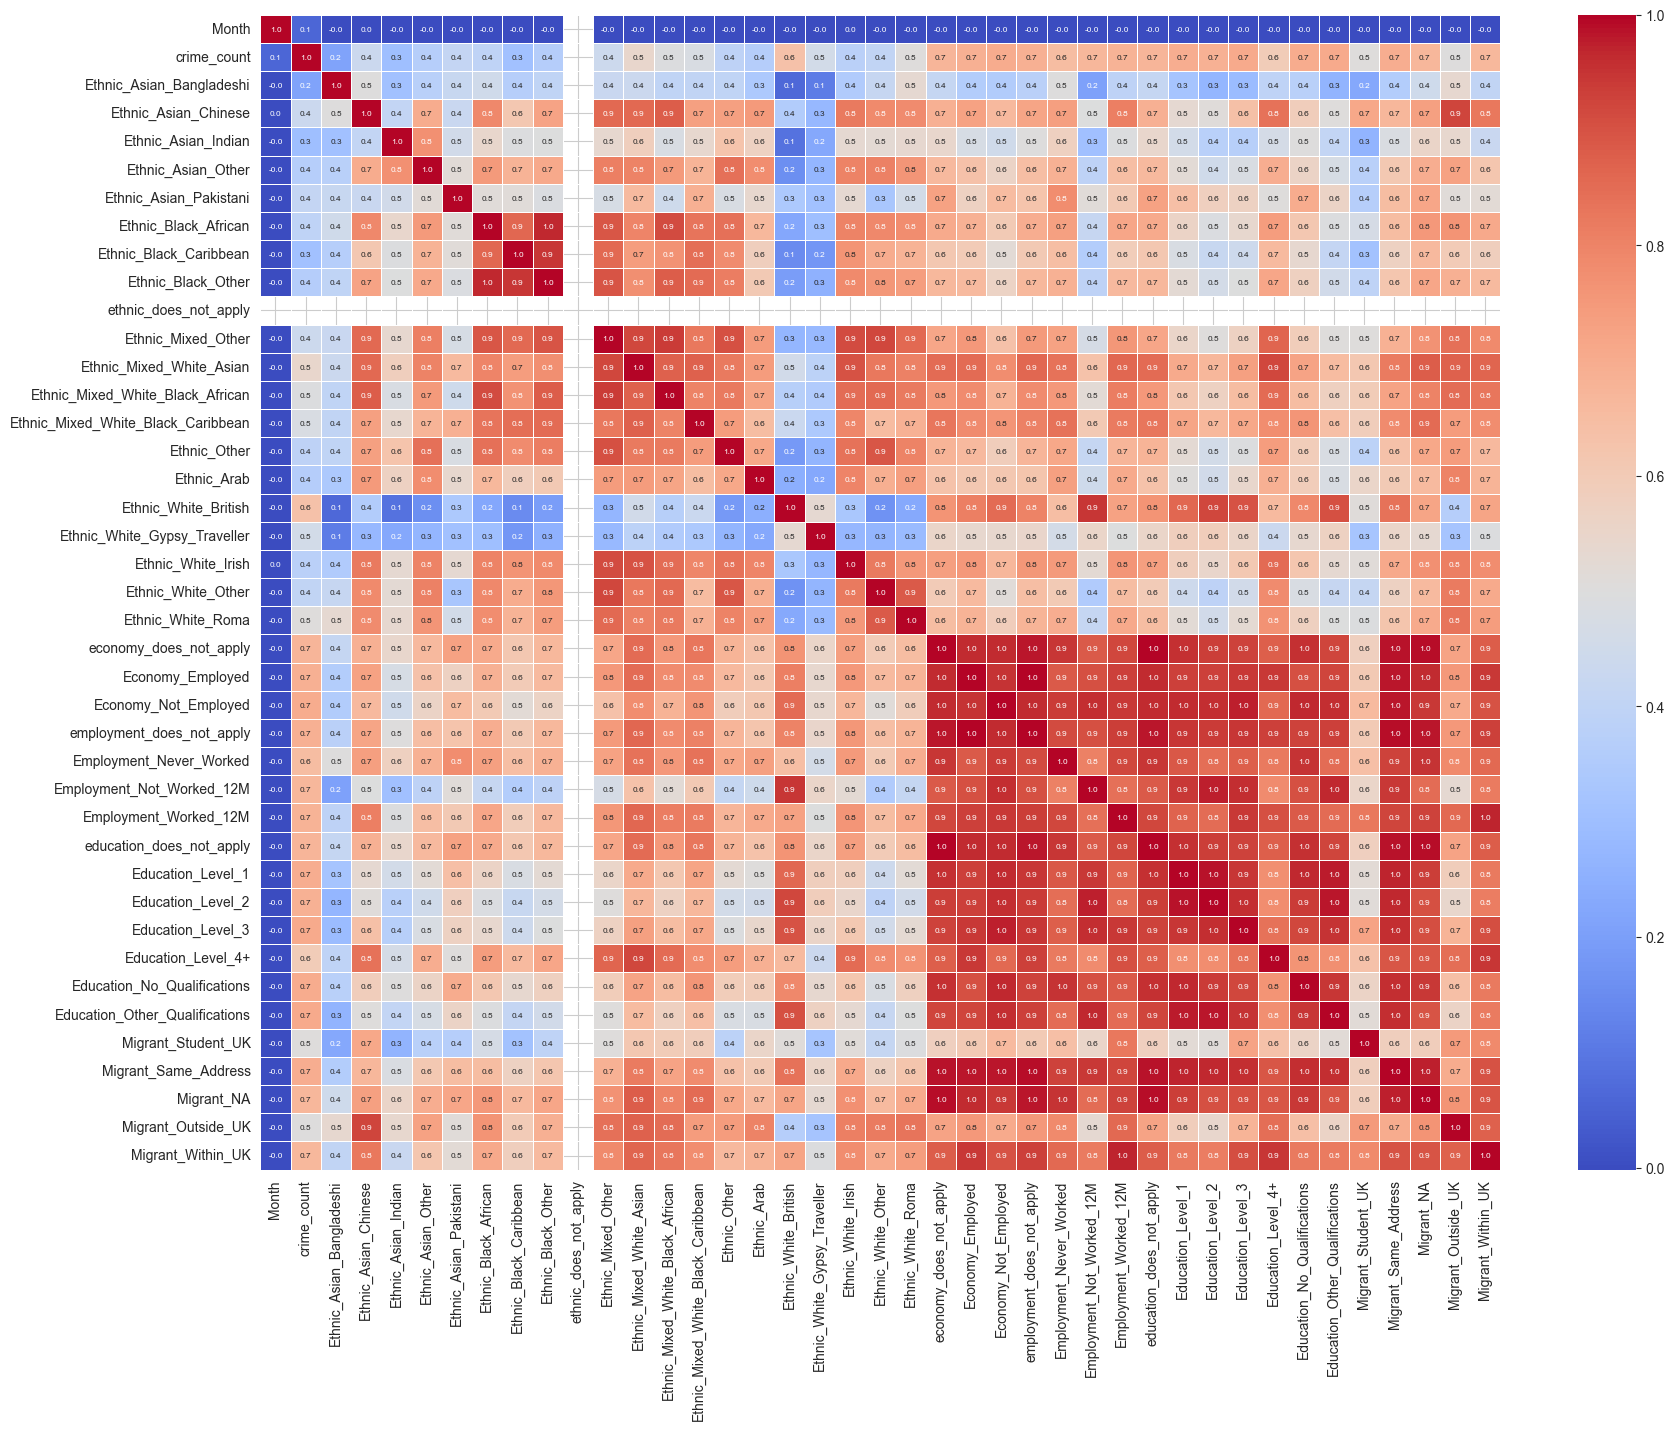

In [8]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set the size of the plot
plt.figure(figsize=(20, 15))  # Increase the figure size for better readability

# Create the heatmap with annotations
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", annot_kws={'size': 6}, cmap='coolwarm', linewidths=.5)

# Rotate the x and y labels for better readability
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.yticks(rotation=0)   # y-axis labels can be left horizontal or adjusted as needed

# Show the plot
plt.show()

In [ ]:
#all changes below are for bayesian network

In [ ]:
import pandas as pd
from pgmpy.models import BayesianNetwork  # Updated class name
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx
import matplotlib.pyplot as plt



# Ensure that all specified variables exist in the DataFrame
expected_vars = {'Migrant_Within_UK', 'Ethnic_White_British', 'Economy_Not_Employed', 'Employment_Worked_12M', 'Education_No_Qualifications', 'crime_count'}
if not expected_vars.issubset(data.columns):
    missing_vars = expected_vars - set(data.columns)
    raise ValueError(f"Missing variables in the DataFrame that are expected in the model: {missing_vars}")

# Define the model structure (DAG)
model = BayesianNetwork([
    ('Migrant_Within_UK', 'crime_count'),
    ('Ethnic_White_British', 'crime_count'),
    ('Economy_Not_Employed', 'crime_count'),
    ('Employment_Worked_12M', 'crime_count'),
    ('Education_No_Qualifications', 'crime_count')
])

# Learning CPDs using Maximum Likelihood Estimators
model.fit(data, estimator=MaximumLikelihoodEstimator)

# Plotting the Bayesian Network using networkx
nx.draw(model, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, pos=nx.spring_layout(model))
plt.show()

# Display the CPDs for each node
for cpd in model.get_cpds():
    print("CPD of {0}:".format(cpd.variable))
    print(cpd)


In [ ]:
data.head()

In [1]:
import pandas as pd

# Load the dataset
file_path = '/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/data_trdnl_mdl_shap_vs_lime.csv'
data = pd.read_csv(file_path)

# Display the first few rows and the general information of the dataset
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Month                               2876 non-null   object
 1   crime_count                         2876 non-null   int64 
 2   Ethnic_Asian_Bangladeshi            2876 non-null   int64 
 3   Ethnic_Asian_Chinese                2876 non-null   int64 
 4   Ethnic_Asian_Indian                 2876 non-null   int64 
 5   Ethnic_Asian_Other                  2876 non-null   int64 
 6   Ethnic_Asian_Pakistani              2876 non-null   int64 
 7   Ethnic_Black_African                2876 non-null   int64 
 8   Ethnic_Black_Caribbean              2876 non-null   int64 
 9   Ethnic_Black_Other                  2876 non-null   int64 
 10  ethnic_does_not_apply               2876 non-null   int64 
 11  Ethnic_Mixed_Other                  2876 non-null   int6

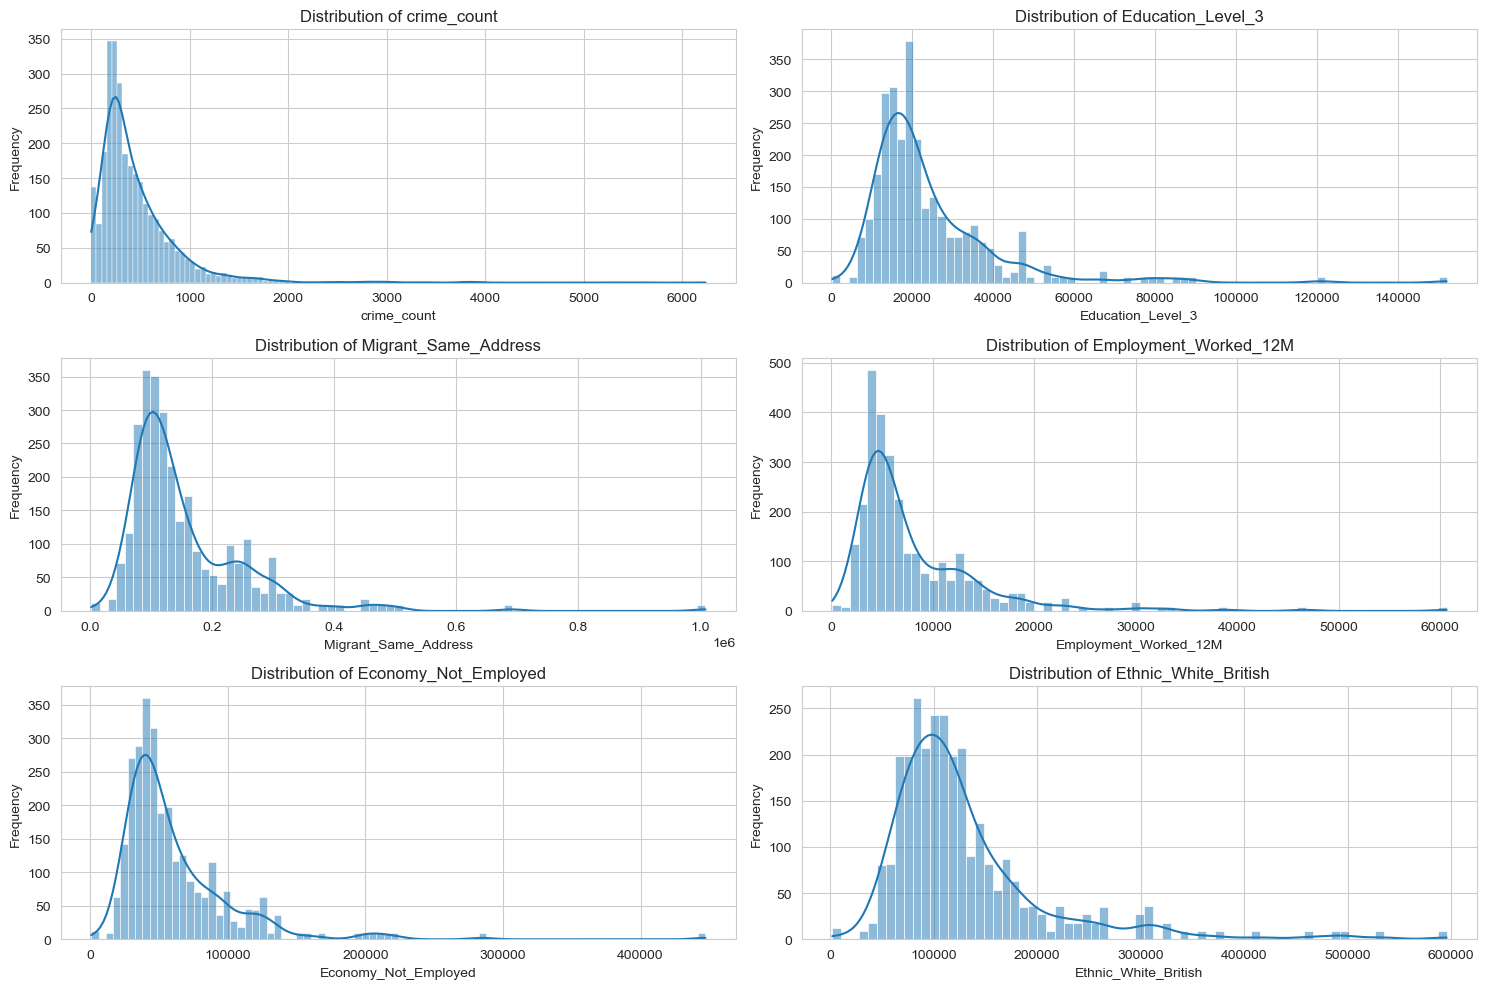

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of key variables
variables = ['crime_count', 'Education_Level_3', 'Migrant_Same_Address',
             'Employment_Worked_12M', 'Economy_Not_Employed', 'Ethnic_White_British']

# Plotting the distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


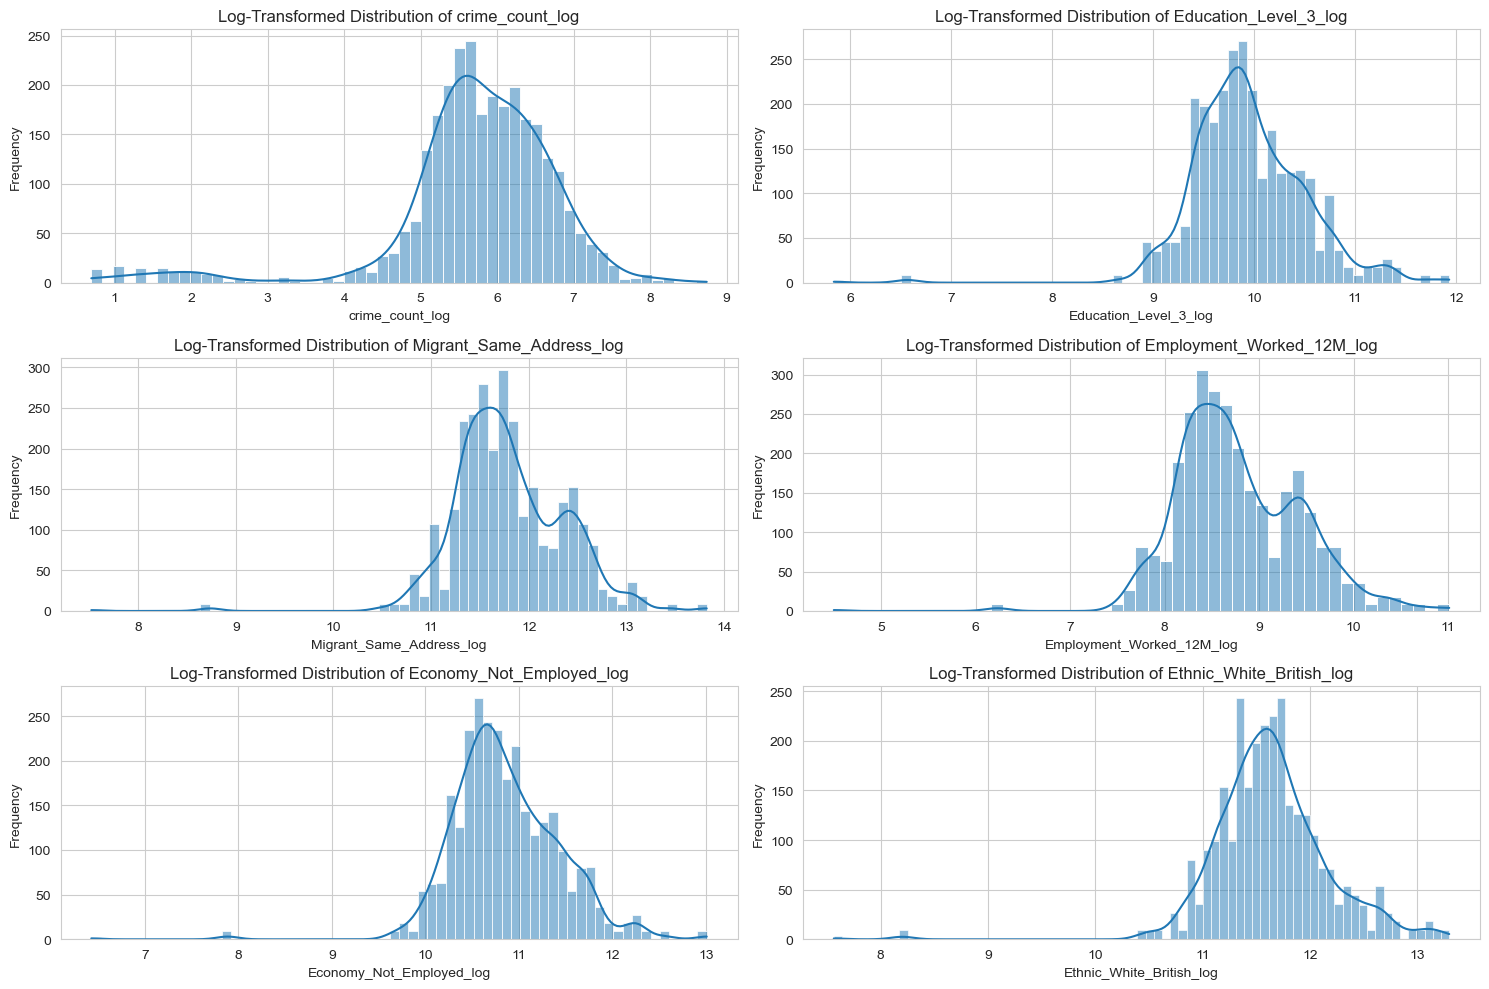

In [3]:
import numpy as np

# Applying logarithmic transformation, adding 1 to avoid log(0) issue
log_transformed_data = data.copy()
log_transformed_data['crime_count_log'] = np.log1p(log_transformed_data['crime_count'])
log_transformed_data['Education_Level_3_log'] = np.log1p(log_transformed_data['Education_Level_3'])
log_transformed_data['Migrant_Same_Address_log'] = np.log1p(log_transformed_data['Migrant_Same_Address'])
log_transformed_data['Employment_Worked_12M_log'] = np.log1p(log_transformed_data['Employment_Worked_12M'])
log_transformed_data['Economy_Not_Employed_log'] = np.log1p(log_transformed_data['Economy_Not_Employed'])
log_transformed_data['Ethnic_White_British_log'] = np.log1p(log_transformed_data['Ethnic_White_British'])

# Plotting the log-transformed distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(['crime_count_log', 'Education_Level_3_log', 'Migrant_Same_Address_log',
                         'Employment_Worked_12M_log', 'Economy_Not_Employed_log', 'Ethnic_White_British_log'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(log_transformed_data[var], kde=True)
    plt.title(f'Log-Transformed Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [4]:
# Applying quantile binning on log-transformed variables
log_binned_data = log_transformed_data.copy()

# Defining the number of bins (e.g., 3 bins for low, medium, high)
n_bins = 3

# Applying quantile binning
log_binned_data['crime_count_binned'] = pd.qcut(log_binned_data['crime_count_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Education_Level_3_binned'] = pd.qcut(log_binned_data['Education_Level_3_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Migrant_Same_Address_binned'] = pd.qcut(log_binned_data['Migrant_Same_Address_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Employment_Worked_12M_binned'] = pd.qcut(log_binned_data['Employment_Worked_12M_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Economy_Not_Employed_binned'] = pd.qcut(log_binned_data['Economy_Not_Employed_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Ethnic_White_British_binned'] = pd.qcut(log_binned_data['Ethnic_White_British_log'], q=n_bins, labels=['Low', 'Medium', 'High'])

# Display the first few rows of the binned data
print(log_binned_data[['crime_count_binned', 'Education_Level_3_binned', 'Migrant_Same_Address_binned',
                       'Employment_Worked_12M_binned', 'Economy_Not_Employed_binned', 'Ethnic_White_British_binned']].head())


  crime_count_binned Education_Level_3_binned Migrant_Same_Address_binned  \
0                Low                      Low                         Low   
1                Low                      Low                         Low   
2             Medium                   Medium                      Medium   
3             Medium                   Medium                      Medium   
4             Medium                   Medium                      Medium   

  Employment_Worked_12M_binned Economy_Not_Employed_binned  \
0                          Low                         Low   
1                          Low                         Low   
2                          Low                      Medium   
3                       Medium                        High   
4                          Low                      Medium   

  Ethnic_White_British_binned  
0                         Low  
1                      Medium  
2                      Medium  
3                        High  
4   

In [5]:
# Convert 'Month' to a datetime object if it isn't already
log_binned_data['Month'] = pd.to_datetime(log_binned_data['Month'])

# Extract the month part and encode it as a categorical variable
log_binned_data['Month_Encoded'] = log_binned_data['Month'].dt.month.astype('category')

# Display the first few rows to verify the changes
print(log_binned_data[['Month', 'Month_Encoded']].head())


       Month Month_Encoded
0 2021-01-01             1
1 2021-01-01             1
2 2021-01-01             1
3 2021-01-01             1
4 2021-01-01             1


In [10]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score


# Selecting the relevant binned and encoded variables for the Bayesian network
bayesian_data = log_binned_data[['Month_Encoded', 'crime_count_binned', 'Education_Level_3_binned',
                                 'Migrant_Same_Address_binned', 'Employment_Worked_12M_binned',
                                 'Economy_Not_Employed_binned', 'Ethnic_White_British_binned']]

# Encoding categorical variables (Month_Encoded is already categorical)
for col in bayesian_data.columns:
    if bayesian_data[col].dtype.name == 'category':
        bayesian_data[col] = bayesian_data[col].cat.codes

# Performing structure learning using Hill-Climb Search and BIC scoring
hc = HillClimbSearch(bayesian_data)
best_model = hc.estimate(scoring_method=K2Score(bayesian_data))

# Display the structure of the learned Bayesian network
print(best_model.edges())


/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_41359/1196227319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayesian_data[col] = bayesian_data[col].cat.codes


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Month_Encoded', 'crime_count_binned'), ('Education_Level_3_binned', 'Ethnic_White_British_binned'), ('Education_Level_3_binned', 'Employment_Worked_12M_binned'), ('Education_Level_3_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Economy_Not_Employed_binned'), ('Migrant_Same_Address_binned', 'Education_Level_3_binned'), ('Migrant_Same_Address_binned', 'Employment_Worked_12M_binned'), ('Migrant_Same_Address_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Employment_Worked_12M_binned'), ('Economy_Not_Employed_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Education_Level_3_binned'), ('Economy_Not_Employed_binned', 'Ethnic_White_British_binned'), ('Ethnic_White_British_binned', 'crime_count_binned')]


In [11]:
# Fit the Bayesian network
model = BayesianNetwork(best_model.edges())
model.fit(bayesian_data, estimator=BayesianEstimator)


In [12]:
# Evaluate the model using BIC score
bic_score = BicScore(bayesian_data).score(model)
print(f"BIC Score: {bic_score}")


BIC Score: -34167.234212962096


In [13]:
from pgmpy.inference import VariableElimination

# Perform inference to determine the most probable causes of high crime_count_binned
inference = VariableElimination(model)
crime_cause = inference.map_query(variables=['crime_count_binned'])
print(f"Most likely cause of crime: {crime_cause}")


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Most likely cause of crime: {'crime_count_binned': 0}


In [14]:
# Ensure 'crime_count_binned' is a categorical type
bayesian_data['crime_count_binned'] = bayesian_data['crime_count_binned'].astype('category')

# Now, you can access the categories
print(bayesian_data['crime_count_binned'].cat.categories)
# Print the categories and their corresponding labels
print(bayesian_data['crime_count_binned'].cat.categories)
# Assuming the model and inference have been set up as before
crime_cause = inference.map_query(variables=['crime_count_binned'])
print(f"Most likely cause of crime: {crime_cause}")


Index([0, 1, 2], dtype='int8')
Index([0, 1, 2], dtype='int8')


/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_41359/4247723632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayesian_data['crime_count_binned'] = bayesian_data['crime_count_binned'].astype('category')


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Most likely cause of crime: {'crime_count_binned': 0}


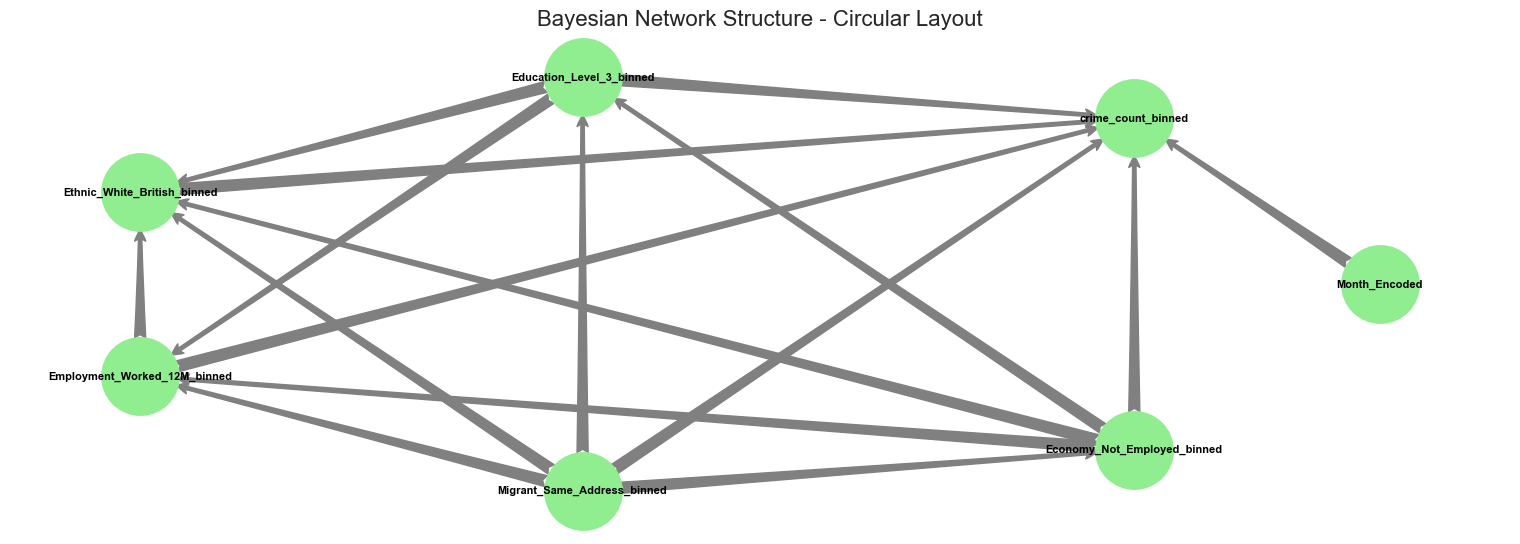

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'model' is your Bayesian network model
# Extracting the structure of the Bayesian Network
edges = model.edges()

# Create a directed graph from the Bayesian network structure
G = nx.DiGraph()
G.add_edges_from(edges)

# Set node positions using a circular layout for better organization
pos = nx.circular_layout(G)  # Circular layout for a more organized appearance

# Draw the network
plt.figure(figsize=(15, 5))  # Increase the figure size for a more spacious view
nx.draw(
    G, pos,
    with_labels=True,
    node_size=3000,  # Even larger nodes
    node_color='lightgreen',  # Softer, calming color for nodes
    font_size=8,  # Slightly larger font for labels
    font_weight='bold',
    edge_color='gray',  # Softer edge color
    linewidths=2,  # Thicker node borders for emphasis
    arrowsize=20,  # Larger arrows for better visibility
    arrowstyle='fancy',  # Different arrow style for a unique look
)

plt.title("Bayesian Network Structure - Circular Layout", fontsize=16)  # Larger title font size
plt.show()


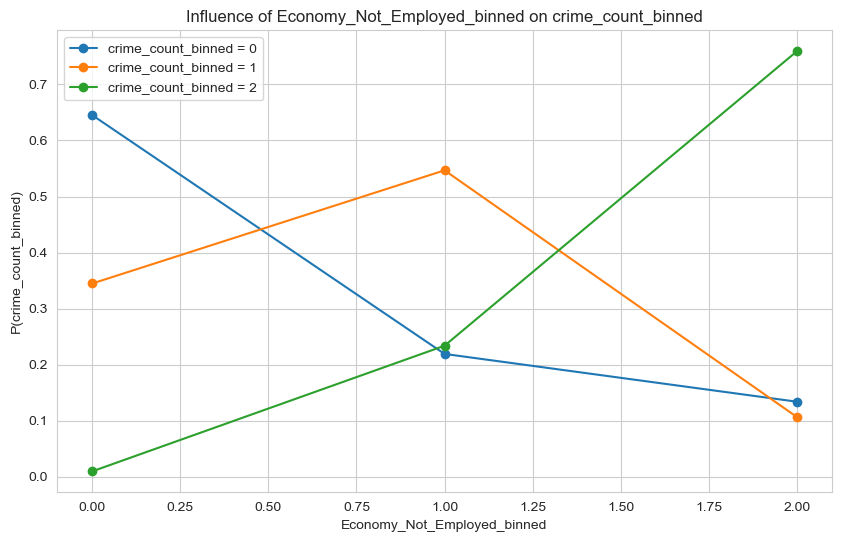

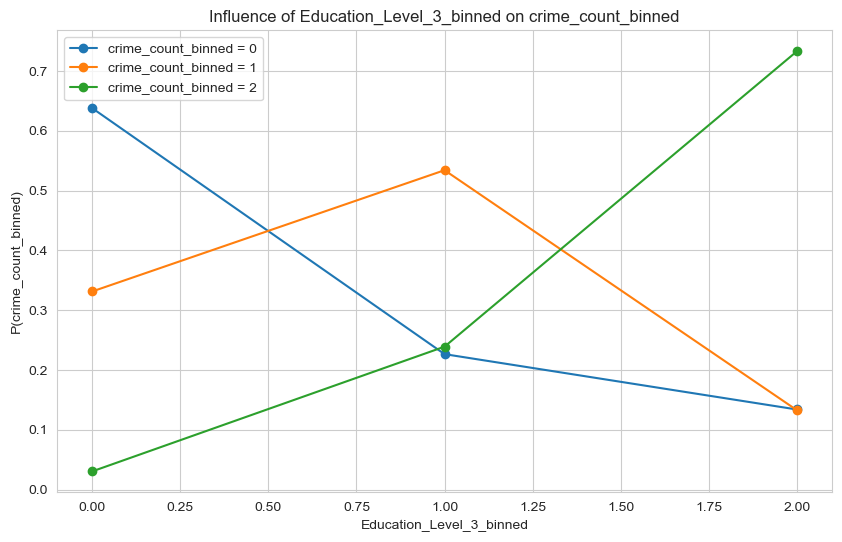

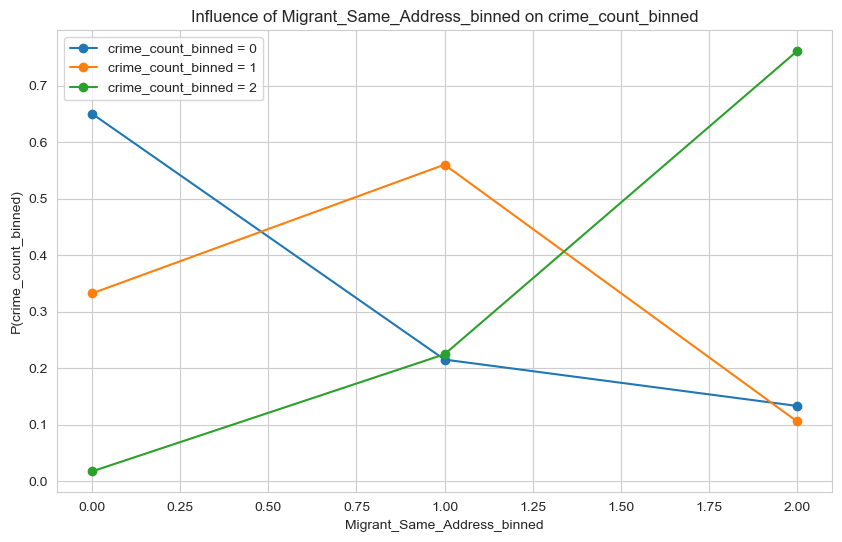

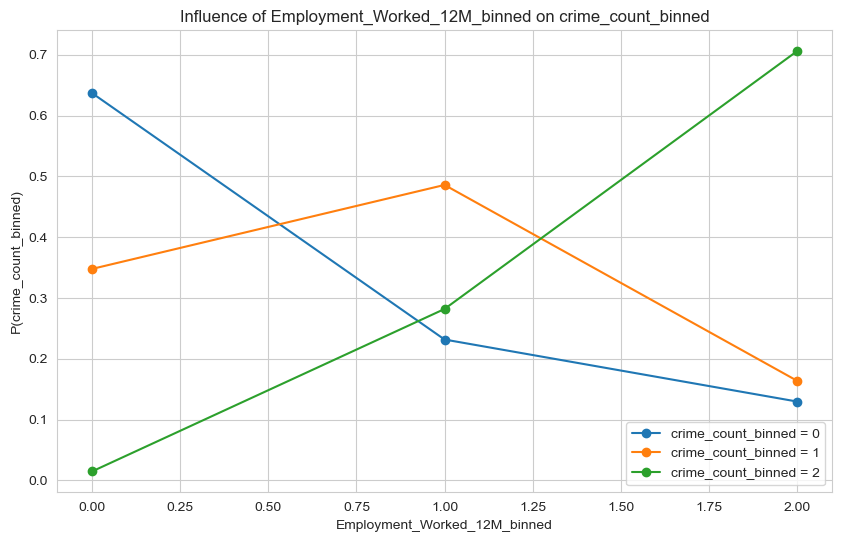

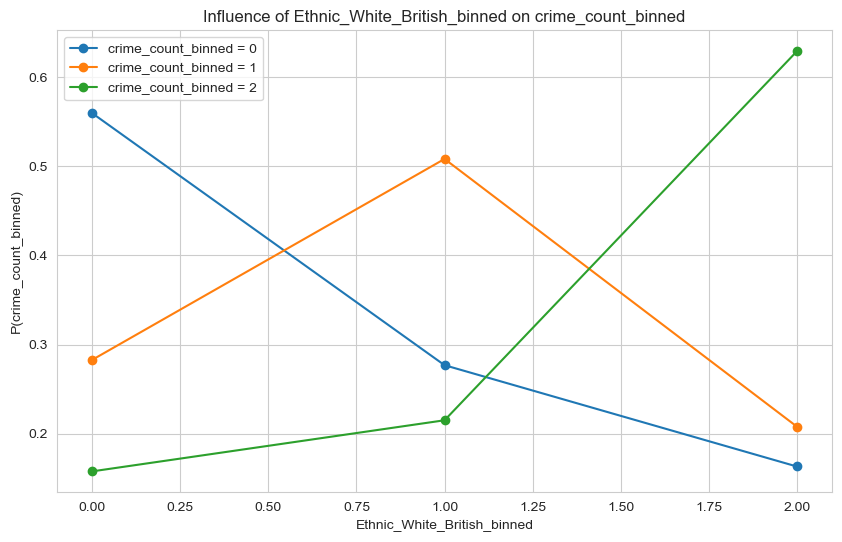

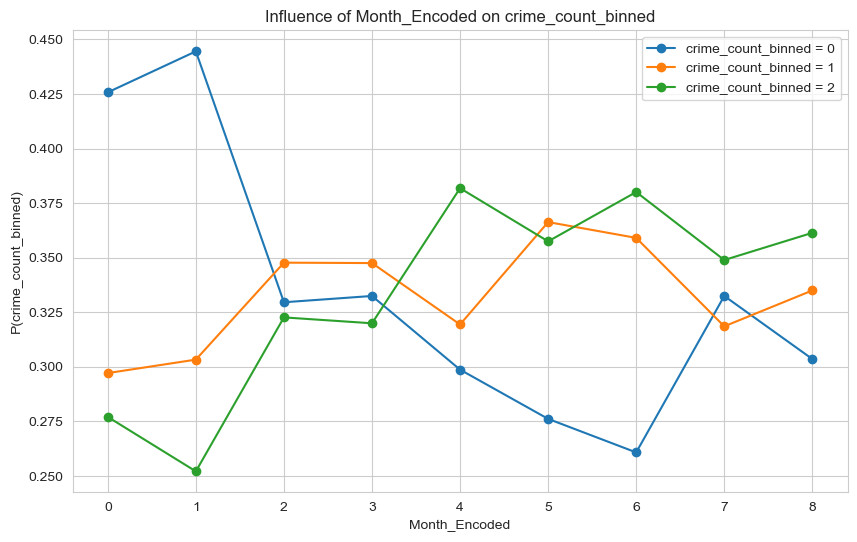

In [17]:
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination

def plot_variable_influence(model, data, target_variable='crime_count_binned', variables_to_plot=None):
    """
    Plots the influence of different variables on the target variable's (crime_count_binned) probability distribution.
    
    :param model: The fitted Bayesian network model.
    :param data: The DataFrame used to fit the model.
    :param target_variable: The target variable to analyze (default is 'crime_count_binned').
    :param variables_to_plot: A list of variables for which to plot influence on the target variable.
    """
    if variables_to_plot is None:
        variables_to_plot = data.columns.tolist()
        variables_to_plot.remove(target_variable)

    # Initialize inference object
    inference = VariableElimination(model)

    for var in variables_to_plot:
        # Get unique values of the variable to plot
        unique_vals = sorted(data[var].unique())
        probabilities = {bin_label: [] for bin_label in data[target_variable].cat.categories}

        for val in unique_vals:
            # Query the model for the probability distribution of the target variable given the current variable's value
            query_result = inference.query(variables=[target_variable], evidence={var: val})
            for bin_label in probabilities:
                probabilities[bin_label].append(query_result.values[bin_label])

        # Plot the results
        plt.figure(figsize=(10, 6))
        for bin_label, prob_values in probabilities.items():
            plt.plot(unique_vals, prob_values, marker='o', label=f'{target_variable} = {bin_label}')

        plt.title(f'Influence of {var} on {target_variable}')
        plt.xlabel(var)
        plt.ylabel(f'P({target_variable})')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
# Assuming 'model' is your Bayesian network model and 'bayesian_data' is your dataset
plot_variable_influence(model, bayesian_data, target_variable='crime_count_binned',
                        variables_to_plot=[ 'Economy_Not_Employed_binned',
                                           'Education_Level_3_binned', 'Migrant_Same_Address_binned',
                                           'Employment_Worked_12M_binned', 'Ethnic_White_British_binned','Month_Encoded'])


In [7]:
!pip install pgmpy


INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 33.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 37.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found exi

In [9]:
from pgmpy.estimators import K2Score

best_model = hc.estimate(scoring_method=K2Score(bayesian_data))
print(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Month_Encoded', 'crime_count_binned'), ('Education_Level_3_binned', 'Ethnic_White_British_binned'), ('Education_Level_3_binned', 'Employment_Worked_12M_binned'), ('Education_Level_3_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Economy_Not_Employed_binned'), ('Migrant_Same_Address_binned', 'Education_Level_3_binned'), ('Migrant_Same_Address_binned', 'Employment_Worked_12M_binned'), ('Migrant_Same_Address_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Employment_Worked_12M_binned'), ('Economy_Not_Employed_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Education_Level_3_binned'), ('Economy_Not_Employed_binned', 'Ethnic_White_British_binned'), ('Ethnic_White_British_binned', 'crime_count_binned')]
